# Práctica 4
### David Davó Laviña

In [0]:
!pip install -q qwikidata

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import itertools as it
import qwikidata.sparql as sparql
from qwikidata.entity import WikidataItem, WikidataProperty, WikidataLexeme
from qwikidata.linked_data_interface import get_entity_dict_from_api

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


En primer lugar, creamos la clase `SimpleCommonItemsSearcher`, que actuará a su vez de chaché para las propiedades y relaciones. También tiene métodos de utilidad como `get_label` o `labelify`, pero el que más nos importa es `common_items(item1, item2, depth)`, que nos retorna los items comunes entre dos a una distancia máxima de `depth`.

In [0]:
class SimpleCommonItemsSearcher:
    AVAILABLE_PROPERTIES = [
        "P31",      # instance of
        "P279",     # subclass of
        "P527",     # has part
        "P1303",    # instrument
        "P136",     # genre
    ]
    entity_cache = {}

    def get_entity(self, item_id):
        if (item_id not in self.entity_cache):
            if item_id is None: return None
            elif item_id[0] == "P":
                self.entity_cache[item_id] = WikidataProperty(get_entity_dict_from_api(item_id))
            elif item_id[0] == "Q":
                self.entity_cache[item_id] = WikidataItem(get_entity_dict_from_api(item_id))
            else:
                raise ValueError(f'item_id {item_id} invalid')

        return self.entity_cache[item_id]

    def get_label(self, item_id):
        e = self.get_entity(item_id)
        return "NULL" if e is None else e.get_label()

    def labelify(self, itemList):
        ret = []

        for item in itemList:
            if isinstance(item, list) or isinstance(item, tuple): ret.append(self.labelify(item))
            else: ret.append(self.get_label(item))

        if isinstance(itemList, tuple): return tuple(ret)
        else: return ret

    def get_claims_values(self, item):
        if not isinstance(item, WikidataItem): item = self.get_entity(item)

        for p in self.AVAILABLE_PROPERTIES:
            for v in item.get_truthy_claim_group(p):
                yield v.mainsnak.datavalue.value["id"]

    def get_claims(self, item):
        if not isinstance(item, WikidataItem): item = self.get_entity(item)

        for p in self.AVAILABLE_PROPERTIES:
            for v in item.get_truthy_claim_group(p):
                if v.mainsnak.datavalue is not None: 
                    yield (p,v.mainsnak.datavalue.value["id"])

    def common_items(self, item1, item2, max_depth=3):
        i = 0
        # Array que tiene el total de elementos en la iteración 'n'
        totalcommon = [set()]
        tocheck = {item1, item2}
        visited = set()
        while (i < max_depth/2):
            common = set()
            for item1, item2 in it.product(tocheck, tocheck):
                if (item1 != item2):
                    itemset1 = set(self.get_claims_values(item1))
                    itemset2 = set(self.get_claims_values(item2))
                    common = common | (itemset1 & itemset2)
                    tocheck = (tocheck | itemset1 | itemset2) - visited

            visited = visited | tocheck
            totalcommon.append(totalcommon[-1] | common)
            i += 1

        # print(item1, item2, totalcommon)

        return totalcommon

In [0]:
ITEMS = [
    "Q5994",        # piano
    "Q1343007",     # electronic keyboard
    "Q2355465",     # String synthesizer
    "Q76364",       # Hans Zimmer
    "Q46717",       # Pirates of the Caribbean: The Curse of the Black Pearl
    "Q36479",       # The Lion King
    "Q171048",      # Toy Story
    "Q192724",      # Iron Man
    # Los siguientes fueron usados para pruebas
    # "Q42",          # Douglas Adams
    # "Q5",           # Human
]

scis = SimpleCommonItemsSearcher()

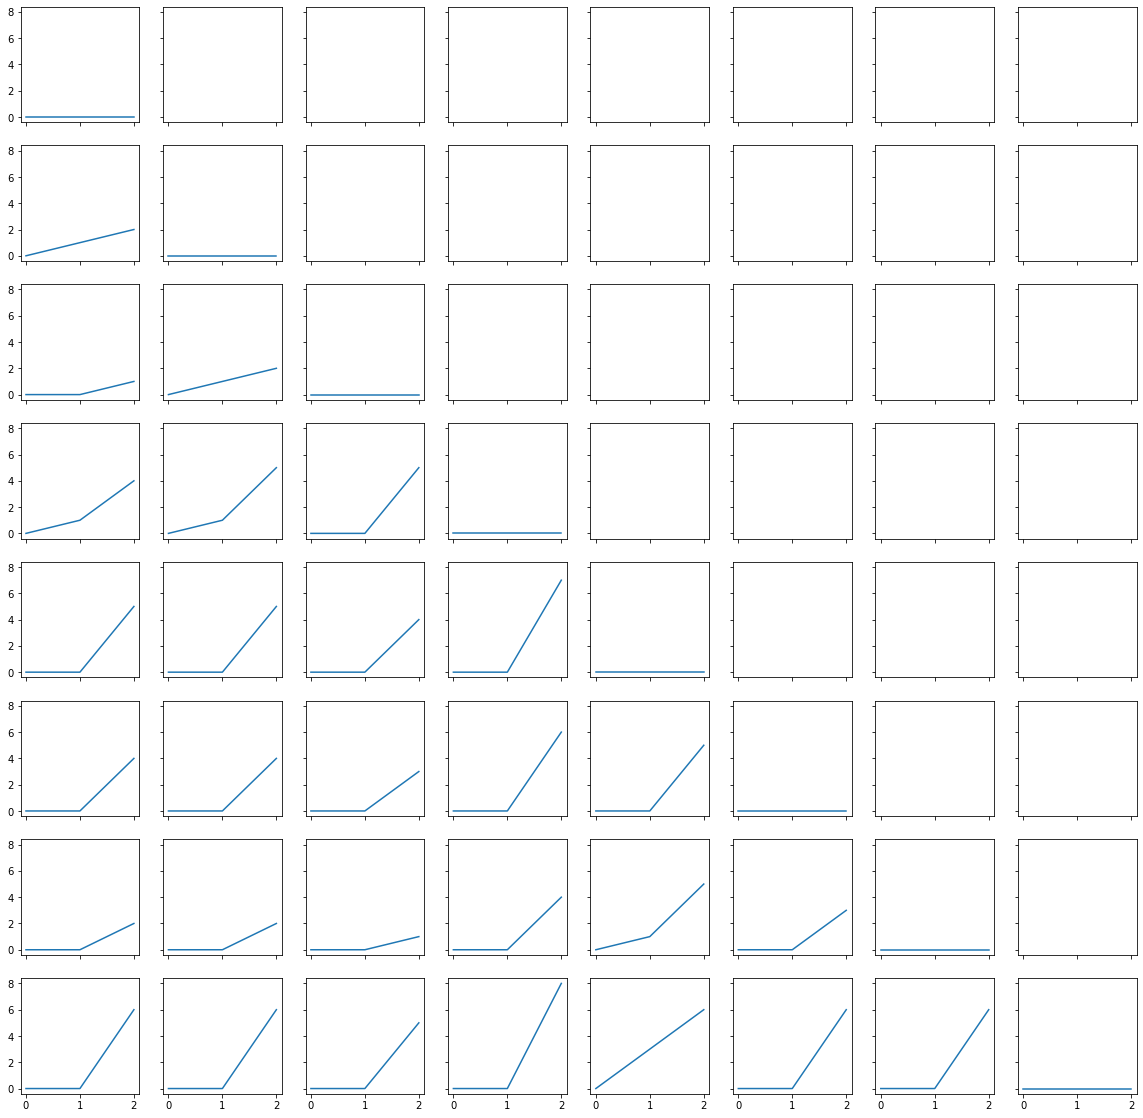

In [5]:
fig,axs = plt.subplots(len(ITEMS), len(ITEMS), sharex=True, sharey=True, squeeze=False)
fig.set_size_inches(20, 20)

results = []
for (i, itemi) in enumerate(ITEMS):
    localresults = []
    for (j, itemj) in enumerate(ITEMS[:i+1]):
        localresults.append(scis.common_items(itemi, itemj))
        axs[i][j].plot(list(map(len, localresults[-1])))
    results.append(localresults)

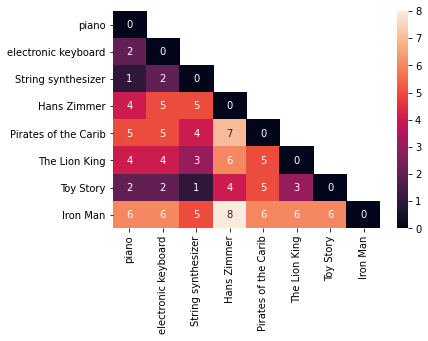

In [6]:
itemsnames = list(map(lambda x: scis.get_label(x)[:20], ITEMS))
df = pd.DataFrame([map(lambda x: len(x[-1]), y) for y in results], index=itemsnames, columns=itemsnames)
sns.heatmap(df, annot=True)

## Parte 2

....................................

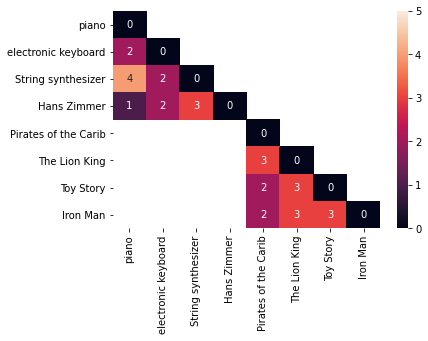

In [11]:
from collections import deque

class ComplexPathSearcher(SimpleCommonItemsSearcher):
    """
    Expands the frontier of nodes
    """
    def _expandfrontier(self, frontier, passed, parent):
        nextfrontier = set()
        for item in frontier:
            for son in self.get_claims(item):
                if son[1] not in passed:
                    passed.add(son[1])
                    nextfrontier.add(son[1])
                    parent[son[1]] = (item, son[0])

        return nextfrontier

    """
    Returns the path followed, in the format of an array of triplets (a, p1, b), (b, p2, c)...
    """
    def _traceback(self, node1, node2, intersectnode, parent1, parent2):
        path1 = []
        nextp = (*parent1[intersectnode], intersectnode)
        while(nextp[1] is not None and nextp[0] != node1):
            path1.insert(0, nextp)
            nextp = (*parent1[nextp[0]], nextp[0])

        if (nextp[1] is not None): path1.insert(0, nextp)

        path2 = []
        nextp = (*parent2[intersectnode], intersectnode, )
        while(nextp[1] is not None and nextp[0] != node2):
            path2.insert(0, nextp)
            nextp = (*parent2[nextp[0]], nextp[0])

        if nextp[1] is not None: path2.insert(0, nextp)

        # print(parent1[node1])
        # print(parent2[node2])
        return (path1, path2)

    """ 
    Returns the min path between two items using bidirectional search
    @returns A tuple with two arrays of triplets in the form (subject, property, object)
    """
    def path_search(self, item1, item2, max_path=5):
        print(".", end='')
        if item1 == item2: return ([], [])
        s1passed = set([item1])
        s2passed = set([item2])

        s1parent = {item1:(None, None)}
        s2parent = {item2:(None, None)}

        # En lugar de usar una cola como en el BFS de toda la vida (o cola de
        # prioridad en A*), usamos una frontera que iremos actualizando con los
        # elementos a resolver e la siguiente iteración
        s1frontier = set([item1])
        s2frontier = set([item2])

        i = 0
        while (i < max_path):
            s1frontier = self._expandfrontier(s1frontier, s1passed, s1parent)
            s2frontier = self._expandfrontier(s2frontier, s2passed, s2parent)

            intersect = s1passed & s2passed

            # Nota: esto es necesario pues habrá caminos de longitud
            # 1 o 2, 3 o 4, 5 o 6, etc...
            # TODO: Hacer que pare si encuentra el de longitud "minima"
            mintraceback = None
            for e in intersect:
                traceback1, traceback2 = self._traceback(item1, item2, e, s1parent, s2parent)
                if mintraceback is None or len(traceback1)+len(traceback2) < len(mintraceback[0]) + len(mintraceback[1]):
                    mintraceback = (traceback1, traceback2)
                if len(mintraceback[0]) + len(mintraceback[1]) == i+1: return mintraceback
            
            if mintraceback is not None:
                if len(mintraceback[0]) + len(mintraceback[1]) <= max_path: return mintraceback
            
            # print(40*"-")
            i += 1

        return None # No path found

MAX_PATH_LEN=5

cps = ComplexPathSearcher()

# Obtenemos una matriz i,j con los resultados (nota: es triangular)
results = [[cps.path_search(itemi, itemj, MAX_PATH_LEN) for itemj in ITEMS[:i+1]] for i,itemi in enumerate(ITEMS)]
# Obtenemos las etiquetas para poner en el plot
itemsnames = list(map(lambda x: cps.get_label(x)[:20], ITEMS))
# Mostramos la longitud de los caminos
hmdata = pd.DataFrame([map(lambda x: len(x[0]) + len(x[1]) if x is not None else float("inf"), j) for j in results], index=itemsnames, columns=itemsnames)

# Numero de aristas entre dos items
sns.heatmap(hmdata, annot=True, vmin=0, vmax=MAX_PATH_LEN)

In [12]:
def humanify(labelified):
    """ Returns a human version of a path """
    retstr = ""

    for tripl in labelified:
        if retstr == "": retstr =  f'{tripl[0]} --({tripl[1]})--> {tripl[2]}'
        else: retstr += f' --({tripl[1]})--> {tripl[2]}'

    return retstr

for i, itemi in zip(results, itemsnames):
    for (path1, path2), itemj in filter(lambda x: x[0] is not None, zip(i, itemsnames)):
        print(f'>> itemi: {itemi}, itemj: {itemj}, len: {len(path1) + len(path2)}')
        if (len(path1) > 0): print(f'{humanify(cps.labelify(path1))}')
        if (len(path2) > 0): print(f'{humanify(cps.labelify(path2))}')
        print()

>> itemi: piano, itemj: piano, len: 0

>> itemi: electronic keyboard, itemj: piano, len: 2
electronic keyboard --(subclass of)--> keyboard instrument
piano --(subclass of)--> keyboard instrument

>> itemi: electronic keyboard, itemj: electronic keyboard, len: 0

>> itemi: String synthesizer, itemj: piano, len: 4
String synthesizer --(instance of)--> electronic musical instrument --(instance of)--> class of instruments
piano --(subclass of)--> true board zithers with resonator box --(instance of)--> class of instruments

>> itemi: String synthesizer, itemj: electronic keyboard, len: 2
String synthesizer --(instance of)--> electronic musical instrument
electronic keyboard --(subclass of)--> electronic musical instrument

>> itemi: String synthesizer, itemj: String synthesizer, len: 0

>> itemi: Hans Zimmer, itemj: piano, len: 1
Hans Zimmer --(instrument)--> piano

>> itemi: Hans Zimmer, itemj: electronic keyboard, len: 2
Hans Zimmer --(instrument)--> keyboard instrument
electronic keyboa